In [2]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00


In [4]:
!pip install pmdarima

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from skforecast.datasets import fetch_dataset

import statsmodels.api as sm
from pmdarima import auto_arima

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

sns.set_theme()

# Decoding Residuals: Diagnosing ARIMA and SARIMA Models

Evaluating a model is a standard step in any training process. When we look at the metrics, we often wonder if the model is good enough or if there's room for improvement. In time series forecasting, residual analysis can provide valuable insights to help refine the model.


Today, I'd like to share how analyzing time series residuals can help with modeling.

- Using a dataset "Monthly expenditure on corticosteroid drugs, Australia" we will build ARIMA and SARIMA models
- We will compare model resudials visually
- We will compare resudials in more formal way




In [ ]:
# Build to models and compare resudials

There are plenty of detailed posts about ARIMA, SARIMA, and how to build them, so I'll just provide a brief refresher here.

ARIMA(p,d,q) model consists of a few parts:      
- Autoregression AR(p): predict the target variable by using a linear combination of its past values(lags), p - number of lags   
- Moving average MA(q): use past forecast errors in a regression-like model, q - order of the model, number of errors to look at.
- Differencing I(d): apply differentiation to make a time series stationary, d - number of times a series should be differenced to become stationary.
   
Combining differencing(I) with autoregression(AR) and a moving average(MA) model results in a non-seasonal ARIMA model.
   
To capture seasonality, the same parameters are applied at the seasonal level, resulting in the SARIMA(p,d,q)(P,D,Q)m model:
- AR(P) - seasonal AR of order P
- MA(Q) - moving avearage of order Q
- D - order of seasonal differencing
- m - frequency, the number of periods after which you expect a pattern to repeat, for example m = 12 for monthly data suggests a yearly seasonal cycle







In [36]:
data = fetch_dataset(name="h2o")

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 1)


Text(0.5, 1.0, 'Monthly expenditure ($AUD) on corticosteroid drugs')

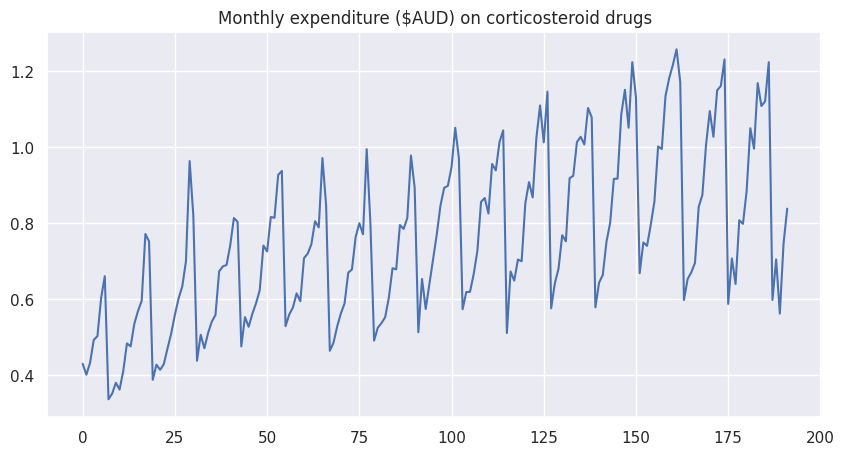

In [28]:
fig = plt.figure(figsize=(10, 5))
plt.plot(data.index, data.x)
plt.title("Monthly expenditure ($AUD) on corticosteroid drugs")

In [ ]:
# It's easy to notice that the dataset has seasinality and trend and STL decomposition proves it

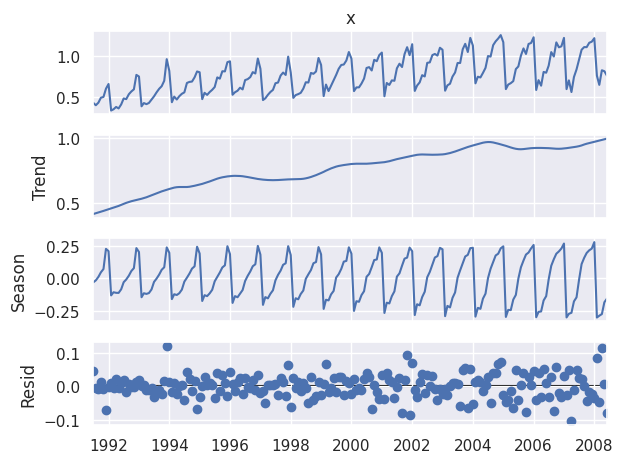

In [31]:
stl = STL(data['x'], seasonal=13)
result = stl.fit()

# Plot components
result.plot()
plt.show()


In [37]:
test_data = data.iloc[-12:]      # Last 12 rows
data = data.iloc[:-12]

# Models building



To build an ARIMA model, we typically need to choose p, d, q, and other seasonal parameters by inspecting ACF and PACF plots. However, this time, let's rely on auto_arima, which can automatically select these parameters. We'll only specify the differencing order to speed up the auto_arima process.

In [57]:
# Select order of differencing
def adfuller_test(y):
    res = adfuller(y)

    print(f"ADF Statistic: {res[0]}")
    print(f"p-value: {res[1]}")

    if res[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary")

    print(" ")

adfuller_test(data['x'])

df_diff = np.diff(data['x'], n=1)
adfuller_test(df_diff)

ADF Statistic: -1.6967562070359845
p-value: 0.43278454683042955
The series is non-stationary
 
ADF Statistic: -3.3659382333938805
p-value: 0.012176310540912193
The series is stationary.
 


# Build two models

In [9]:
# Automatically determine optimal (p, d, q) and (P, D, Q, s)
arima_model = auto_arima(data['x'],
                      start_p=1,
                      start_q=1,
                      test='adf',
                      tr=5, max_q=5, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=1,
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=True,
                      error_action='warn',
                      suppress_warnings=True,
                      stepwise=False)
arima_model.summary()


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-164.132, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-165.135, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-164.429, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-164.806, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-176.000, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-163.386, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-161.702, Tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  192
Model:               SARIMAX(4, 1, 1)   Log Likelihood                 114.325
Date:                Wed, 20 Nov 2024   AIC                           -214.649
Time:                        21:49:08   BIC                           -191.883
Sample:                    07-01-1991   HQIC                          -205.428
                         - 06-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.001      2.487      0.013       0.000       0.003
ar.L1          0.5974      0.120      4.979      0.000       0.362       0.833
ar.L2          0.0030      0.111      0.027      0.978      -0.214       0.220
ar.L3         -0.0522      0.125     -0.416      0.677      -0.298       0.194
ar.L4         -0.2913      0.112     -2.606      0.009      -0.510      -0.072
ma.L1         -0.9624      0.046    -20.912      0.000      -1.053      -0.872
sigma2         0.0174      0.002     10.287      0.000       0.014       0.021
===================================================================================
Ljung-Box (L1) (Q):                   1.88   Jarque-Bera (JB):               129.61
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Seasonal - fit stepwise auto-ARIMA
sarima_model = auto_arima(data["x"], start_p=2, start_q=2,
                         test='adf',
                         max_p=5, max_q=5,
                         m=12, #12 is the frequncy of the cycle
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5,
                         seasonal=True, #set to seasonal
                         d=1,
                         D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-541.646, Time=4.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-430.658, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-504.931, Time=1.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-536.666, Time=0.61 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=-542.275, Time=2.12 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=-521.854, Time=0.85 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=-543.059, Time=5.23 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=-543.644, Time=8.84 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=-542.863, Time=5.74 sec
 ARIMA(2,1,2)(1,1,3)[12]             : AIC=inf, Time=12.57 sec
 ARIMA(2,1,2)(0,1,3)[12]             : AIC=-533.564, Time=13.09 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=-544.936, Time=5.36 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=-545.293, Time=4.75 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-531.638, Time=1.37 sec
 ARIMA(2,1,2)(3,1,0)[1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 278.576
Date:                            Wed, 20 Nov 2024   AIC                           -547.153
Time:                                    21:51:39   BIC                           -531.216
Sample:                                07-01-1991   HQIC                          -540.691
                                     - 06-01-2007                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8307      0.066    -12.514      0.000      -0.961      -0.701
ar.L2         -0.3896      0.066     -5.893      0.000      -0.519      -0.260
ar.S.L12      -0.3882      0.068     -5.668      0.000      -0.522      -0.254
ar.S.L24      -0.3462      0.081     -4.295      0.000      -0.504      -0.188
sigma2         0.0025      0.000     10.011      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.74   Prob(JB):                         0.23
Heteroskedasticity (H):               1.68   Skew:                            -0.11
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Now we have to fitted models. Time to explore resuduals

# Resudials analysis


Residuals in a time series model are the differences between the observed values and the fitted values after applying the model. They provide insights into how well the model has captured the underlying data.
  
A good model should should resemble white noise with following properties:
   
1. Residuals should be uncorrelated. If correlations exist among the residuals, it suggests there is remaining information in the residuals that could be used for better forecasts.
2. Residuals should have a mean of zero. If the mean is not zero, the model's forecasts may be biased.
  
If a forecasting method does not meet these conditions, it can likely be improved. However, even methods that satisfy these criteria can still be enhanced.
  
Additionally, while not strictly necessary, it’s helpful for the residuals to exhibit two more properties:
  
3. Residuals should have constant variance, known as "homoscedasticity."
4. Residuals should be normally distributed.
  
In order to explore these properties we can visualize resudials using method plot_diagnostics from ARIMA model:

1. Standardized residuals over time.
 - A simple time series plot of the residuals.
 - Helps identify patterns or trends in the residuals that may indicate model inadequacy.
 - Ideally, residuals should appear as white noise (randomly scattered around zero with no discernible patterns).
2. Histogram plus estimated density.
 - A smoothed histogram of the residuals, overlaid with a normal distribution curve.
 - Indicates whether the residuals are approximately normally distributed.
 - Significant deviations suggest a potential bias or issue with the model.  
3. Normal Q-Q plot, with Normal reference line
 - Compares the quantiles of the residuals against a standard normal distribution.
 - Points should align along the diagonal line if residuals are normally distributed.
 - Deviations from the line indicate non-normality.
4. Correlogram (ACF plot)
 - Displays the autocorrelation of residuals at various lags.
 - Useful for checking the independence of residuals.
 - Ideally, all correlations should fall within the 95% confidence bounds, indicating no significant autocorrelation.

Notice: In case if ARIMA model is not used, such plots can be reproduced with matplotlib or seaborn.  

In [ ]:
# Arima Model

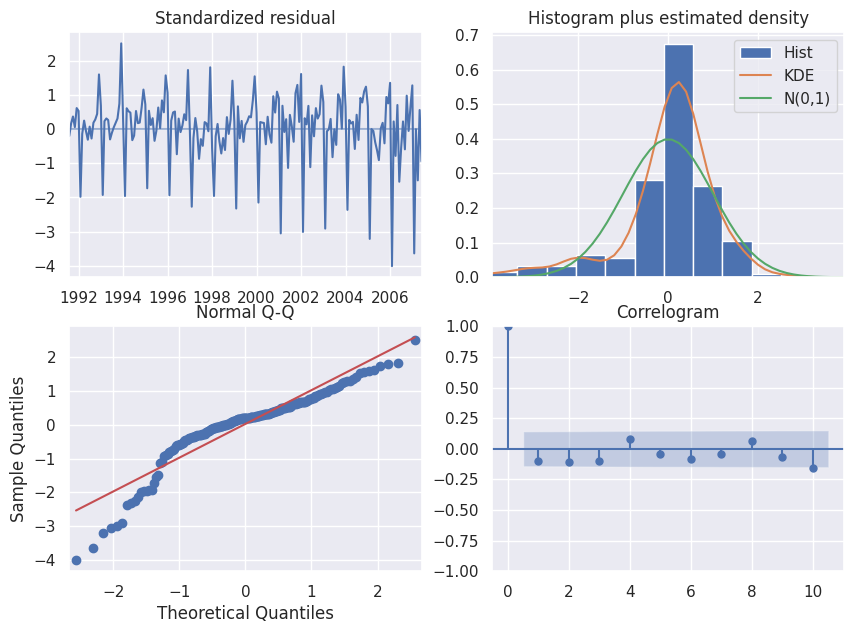

In [27]:
arima_model.plot_diagnostics(figsize=(10,7))
plt.show()

ARIMA Results:
1. Standardized residuals over time - a pattern can be clearly seen hence it's not a white noise.
2. Histogram plus estimated density - resuduals are not normaly distributed
3. Normal Q-Q plot - points strongly deviate from normal distribution
4. Correlogram (ACF plot) - autocorrelaction on lag 10

Overall this means that ARIMA model is not well fitted and should be improved.


In [ ]:
# Sarima model

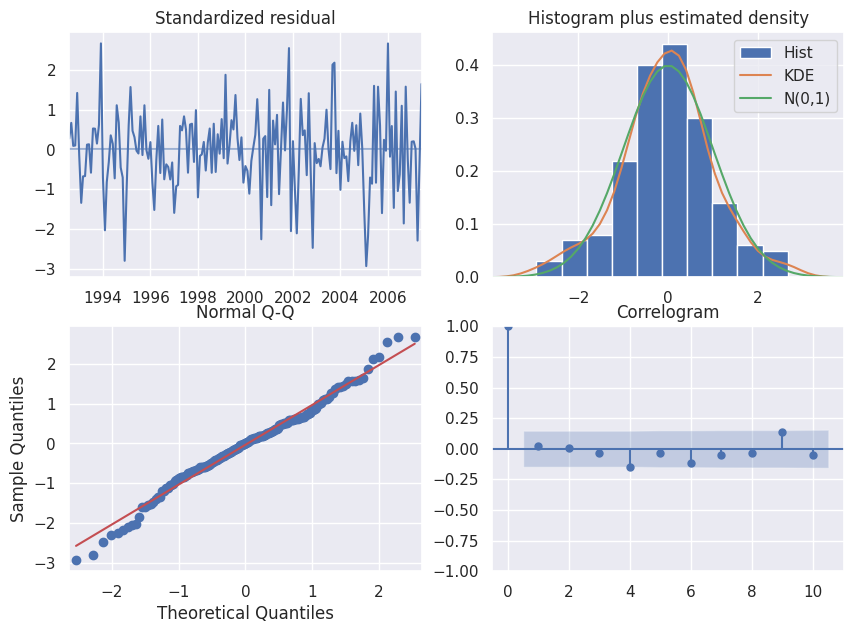

In [26]:
sarima_model.plot_diagnostics(figsize=(10,7))
plt.show()


SARIMA Results:
1. Standardized residuals over time - looks like a white noise.
2. Histogram plus estimated density - resuduals are very close to normaly distributed
3. Normal Q-Q plot - close to a normal distribution
4. Correlogram (ACF plot) - no autocorrelaction

Overall this means that SARIMA model is well fitted (again, it doesn't mean that model can't be improved)

# Formal test, Ljung-Box test

In addition to looking at the ACF plot, we can also do a more formal test for autocorrelation by considering a whole set of resudial values as a group, rather than treating each one separatly.


The Ljung-Box test is a statistical test used to determine whether a set of residuals from a time series model exhibits significant autocorrelation. It is commonly used in time series analysis to check the adequacy of a fitted model, such as ARIMA or SARIMA, by testing whether the residuals are independent.

Hypotheses.  
Null Hypothesis (H₀): The residuals are independently distributed (no autocorrelation).  
Alternative Hypothesis (H₁): The residuals exhibit autocorrelation.
  
Rejecting the null hypothesis implies that the model’s residuals are not independent, suggesting the model may need further refinement.

## How the Test Works
Inputs:
- A time series of residuals from a model.
- A lag 𝑘, up to which autocorrelation is tested.
- Significance level (commonly 0.05 or 0.01).

Test Statistic:
The Ljung-Box test uses the following statistic:

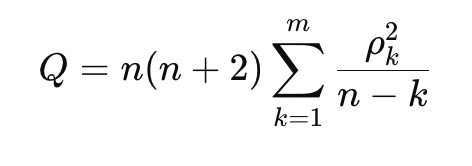


Where:

𝑛 - Number of observations in the residuals.
𝜌𝑘 - Sample autocorrelation at lag 𝑘.
𝑚 - Number of lags being tested.

Distribution:
The test statistic 𝑄 is approximately chi-squared (𝜒2) distributed with
𝑚 degrees of freedom.

P-value:
The p-value indicates the probability of observing the data if the null hypothesis is true.
If 𝑝 -value < significance level, reject 𝐻0

Important:

Choosing the number of lags for the Ljung-Box test (or other time series diagnostics) is crucial to balance between detecting autocorrelation patterns and maintaining statistical power.
Here's a few recomendation how to choose an appropriate number of lags:
1. Length of the Time Series:   
The number of lags should generally be much smaller than the number of observations in the series.
Rule of thumb: Use $\sqrt{N}$, where 𝑁 is the number of observations.
2. Frequency of the Data:   
Consider the natural periodicity of the data.
For monthly data, test lags around 12 (one year).
For daily data with weekly seasonality, test lags around 7.
3. Domain Knowledge:  
Use domain-specific insights to focus on meaningful lag ranges.
E.g., in sales, consider lags that align with known business cycles or seasonality.

In [21]:
def ljung_box_test_print(resid):
    ljung_box_test = acorr_ljungbox(resid, lags=[12], return_df=False)
    if ljung_box_test.lb_pvalue.values < 0.05:
        print("Reject H0. Autocorrelation in the residuals! Model can be improved")
    else:
        print("Great! Failed to Reject 𝐻0. Resudials are a white noise")
    print()
    print(ljung_box_test)



In [22]:
# Null Hypothesis (H₀): The residuals are independently distributed (no autocorrelation)
print("ARIMA model")
ljung_box_test_print(arima_model.resid())

ARIMA model
Reject H0. Autocorrelation in the residuals! Model can be improved

      lb_stat     lb_pvalue
12  141.42236  3.091333e-24


In [23]:
print("SARIMA model")
ljung_box_test_print(sarima_model.resid())

SARIMA model
Great! Failed to Reject 𝐻0. Resudials are a white noise

      lb_stat  lb_pvalue
12  18.694576   0.096171


In [ ]:
# Final plot and MAPE

In [38]:
arima_preds = arima_model.predict(n_periods=12, return_conf_int=False)
sarima_preds = sarima_model.predict(n_periods=12, return_conf_int=False)

arima_preds = arima_preds.reset_index()
sarima_preds = sarima_preds.reset_index()

arima_preds.columns = ['date', 'x']
sarima_preds.columns = ['date', 'x']

arima_in_sample = arima_model.predict_in_sample(start=1, end=data["x"].shape[0])
sarima_in_sample = sarima_model.predict_in_sample(start=1, end=data["x"].shape[0])

arima_in_sample = arima_in_sample.reset_index()
arima_in_sample.columns = ['date', 'x']

sarima_in_sample = sarima_in_sample.reset_index()
sarima_in_sample.columns = ['date', 'x']

data = data.reset_index()
data.columns = ['date', 'x']

test_data = test_data.reset_index()
test_data.columns = ['date', 'x']

Text(0.5, 1.0, 'Fitted vs Observed values')

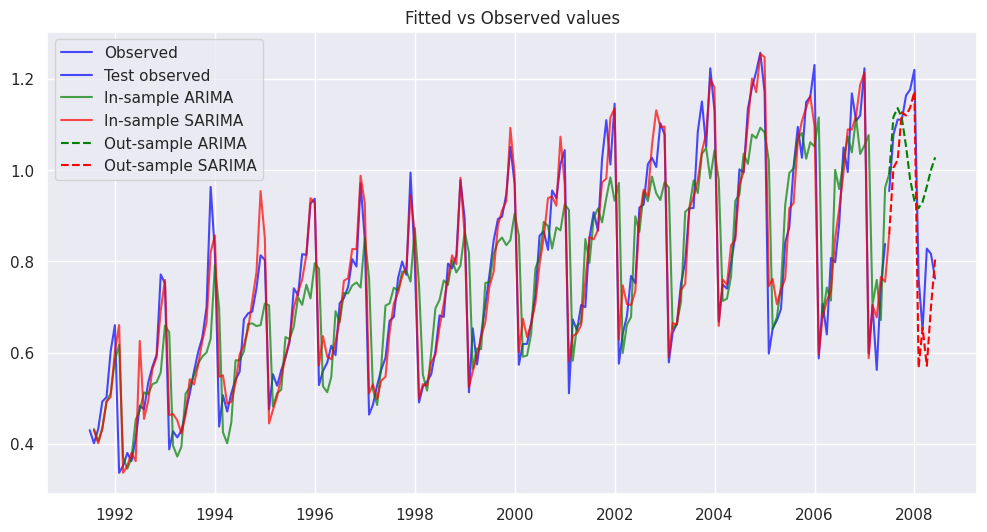

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['x'], label='Observed', color='blue', alpha = 0.7)
plt.plot(test_data['date'], test_data['x'], label='Test observed', color='blue', alpha = 0.7)

plt.plot(arima_in_sample['date'], arima_in_sample['x'], label='In-sample ARIMA', color='green', alpha = 0.7)
plt.plot(sarima_in_sample['date'], sarima_in_sample['x'], label='In-sample SARIMA', color='red', alpha = 0.7)

plt.plot(arima_preds.date, arima_preds['x'], label='Out-sample ARIMA', color='green', linestyle = '--')
plt.plot(sarima_preds.date, sarima_preds['x'], label='Out-sample SARIMA', color='red', linestyle = '--')

plt.legend()
plt.title('Fitted vs Observed values')

In [53]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAPE ARIMA on train", mean_absolute_percentage_error(data['x'], arima_in_sample['x']))
print("MAPE SARIMA on train ", mean_absolute_percentage_error(data['x'], sarima_in_sample['x']))
print()
print("MAPE ARIMA on test", mean_absolute_percentage_error(test_data['x'], arima_preds['x']))
print("MAPE SARIMA on test ", mean_absolute_percentage_error(test_data['x'], sarima_preds['x']))


MAPE ARIMA on train 8.678654800002173
MAPE SARIMA on train  10.417975753986513

MAPE ARIMA on test 16.445658994341894
MAPE SARIMA on test  9.560951898625268
